# General information

In this notebook, I am laying the basis for how machine learning can be utilized to predict waiting times of new clients joining a waiting queue. I am using a dataset published by Bishop et al.(http://eprints.covenantuniversity.edu.ng/10898/1/DIB_Bishop_queue.pdf) that includes information regarding queues formed and served in 3 banks in Ogun State, Nigeria, over a period of 4 weeks.

## Importing libraries

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow.python import keras

# Functions declaration

In [3]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i

In [4]:
def file_read(path, numberOfRows):
    indexCounter = 0
    with open(path,'r') as file:
        nRows = numberOfRows
        nColumns = 4
        dataset = np.zeros(shape=(nRows, nColumns))
        arrivalTimes = []
        for line in file:
            try:
                dataInstance = line.split(',')
                arrivalTime = dataInstance[1] #splits the line at the comma and takes the first bit
                arrivalTime = dt.datetime.strptime(arrivalTime, '%H:%M')
                arrivalHour = arrivalTime.hour
                arrivalMinute = arrivalTime.minute
                waitingMinutes = dataInstance[2]
                serviceMinutes = dataInstance[3]

                arrivalTimes.append(arrivalTime)
                dataset[indexCounter] = [arrivalHour, arrivalMinute, waitingMinutes, serviceMinutes]
                indexCounter = indexCounter + 1
            except:
                #print('index' + str(indexCounter) + 'error')
                pass
    return dataset, arrivalTimes

# Data loading and overview

In [5]:
filenames = []
rootFilePath = './BankDataCsv/'
fullDataset = pd.DataFrame()

for bankCounter in range(3):
    for weekCounter in range(4):
        for dayCounter in range(5):
            filename = 'Bank' + str(bankCounter + 1) + 'Week' + str(weekCounter + 1) + 'Day' + str(dayCounter + 1)
            fullPath = rootFilePath + filename + '.csv'
            filenames.append(fullPath)
            
            numberOfRows = file_len(fullPath) - 1
            print ('Reading ' + filename + 'that contains' + numberOfRows + ' entries')
            tempFeatures, tempArrivalTimes = file_read(rootFilePath + filename + '.csv', numberOfRows)
            dfTempFeatures = pd.DataFrame(np.array(tempFeatures), columns=['hour', 'minutes', 'waitingTime', 'serviceTime'])
            dfTempArrivalTimes = pd.DataFrame(np.array(tempArrivalTimes), columns=['arrivalTime'])
            
            timeLeavingTheQueue = []
            for arrivalTimeCounter in range(numberOfRows):
                timeLeavingTheQueue.append(dfTempArrivalTimes.at[arrivalTimeCounter, 'arrivalTime'] + pd.Timedelta(minutes = dfTempFeatures.at[arrivalTimeCounter, 'waitingTime']))
            dftimeLeavingTheQueue = pd.DataFrame(np.array(timeLeavingTheQueue), columns=['timeLeavingTheQueue'])

            waitingPeople = np.zeros(numberOfRows)
            for i in range(numberOfRows):
                for j in range(i):
                    if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheQueue.at[j, 'timeLeavingTheQueue']):
                        waitingPeople[i] += 1
            dfWaitingPeople = pd.DataFrame(np.array(waitingPeople), columns=['waitingPeople'])
            
            dayOfWeek = np.zeros(numberOfRows)
            for i in range(numberOfRows):
                dayOfWeek[i] = dayCounter
            dfDayOfWeek = pd.DataFrame(np.array(dayOfWeek), columns=['dayOfWeek'])
            
            dfWaitingPeople['waitingPeople'] = dfWaitingPeople['waitingPeople'].astype(int)
            dfTempFeatures['hour'] = dfTempFeatures['hour'].astype(int)
            dfTempFeatures['minutes'] = dfTempFeatures['minutes'].astype(int)
            dfDayOfWeek['dayOfWeek'] = dfDayOfWeek['dayOfWeek'].astype(int)
    
            tempDataset = pd.concat([dfTempFeatures, dfWaitingPeople, dfDayOfWeek], axis=1)
        
            fullDataset = pd.concat([fullDataset, tempDataset], axis=0)
          
fullDataset = fullDataset.reset_index(drop = True)
print(fullDataset.shape[0])

Reading Bank1Week1Day1
879
Reading Bank1Week1Day2
719
Reading Bank1Week1Day3
1019
Reading Bank1Week1Day4
801
Reading Bank1Week1Day5
521
Reading Bank1Week2Day1
988
Reading Bank1Week2Day2
683
Reading Bank1Week2Day3
547
Reading Bank1Week2Day4
1020
Reading Bank1Week2Day5
788
Reading Bank1Week3Day1
999
Reading Bank1Week3Day2
989
Reading Bank1Week3Day3
1000
Reading Bank1Week3Day4
1050
Reading Bank1Week3Day5
981
Reading Bank1Week4Day1
856
Reading Bank1Week4Day2
980
Reading Bank1Week4Day3
1056
Reading Bank1Week4Day4
898
Reading Bank1Week4Day5
996
Reading Bank2Week1Day1
1034
Reading Bank2Week1Day2
789
Reading Bank2Week1Day3
1001
Reading Bank2Week1Day4
909
Reading Bank2Week1Day5
930
Reading Bank2Week2Day1
747
Reading Bank2Week2Day2
923
Reading Bank2Week2Day3
871
Reading Bank2Week2Day4
764
Reading Bank2Week2Day5
889
Reading Bank2Week3Day1
970
Reading Bank2Week3Day2
684
Reading Bank2Week3Day3
723
Reading Bank2Week3Day4
872
Reading Bank2Week3Day5
604
Reading Bank2Week4Day1
1016
Reading Bank2Week4Da

In [6]:
print(f'The dataset has {fullDataset.shape[0]} rows and {fullDataset.shape[1]} columns.')

The dataset has 52444 rows and 6 columns.


In [7]:
fullDataset.head()

,hour,minutes,waitingTime,serviceTime,waitingPeople,dayOfWeek
0,8,0,11.0,28.0,0,0
1,8,0,13.0,25.0,1,0
2,8,0,14.0,26.0,2,0
3,8,0,9.0,26.0,3,0
4,8,0,14.0,23.0,4,0


In [8]:
fullDataset.describe()

,hour,minutes,waitingTime,serviceTime,waitingPeople,dayOfWeek
count,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000
mean,10.672222,27.799176,13.182309,13.549176,29.487434,1.956582
std,2.149174,17.399535,5.954886,5.906969,17.753335,1.409731
min,8.000000,0.000000,3.000000,4.000000,0.000000,0.000000
25%,9.000000,13.000000,9.000000,9.000000,17.000000,1.000000
50%,10.000000,27.000000,12.000000,13.000000,26.000000,2.000000
75%,13.000000,43.000000,16.000000,17.000000,37.000000,3.000000
max,14.000000,59.000000,35.000000,36.000000,110.000000,4.000000


In [13]:
print(f'There are {fullDataset.isnull().any().sum()} columns in the dataset with missing values.')

There are 0 columns in the dataset with missing values.


## Data exploration

In [14]:
myMean = fullDataset["waitingTime"].mean()
print(f'The mean waiting time in the dataset is {myMean} minutes.')

The mean waiting time in the dataset is 13.182308748379224 minutes.


In [15]:
myMedian = fullDataset["waitingTime"].median()
print(f'The median waiting time in the dataset is {myMedian} minutes.')

The median waiting time in the dataset is 12.0 minutes.


In [16]:
myStd = fullDataset["waitingTime"].std()
print(f'The standard deviation of the waiting time in the dataset is {myStd} minutes.')

The standard deviation of the waiting time in the dataset is 5.954886275797915 minutes.


In [17]:
myMean2 = fullDataset["waitingPeople"].mean()
print(f'The mean of the waiting people variable in the dataset is {myMean2} minutes.')

The mean of the waiting people variable in the dataset is 29.487434215544198 minutes.


In [18]:
myMedian2 = fullDataset["waitingPeople"].median()
print(f'The median of the waiting people variable in the dataset is {myMean2} minutes.')

The median of the waiting people variable in the dataset is 29.487434215544198 minutes.


In [19]:
myStd2 = fullDataset["waitingPeople"].std()
print(f'The standard deviation of the waiting people variable in the dataset is {myStd} minutes.')

The standard deviation of the waiting people variable in the dataset is 5.954886275797915 minutes.


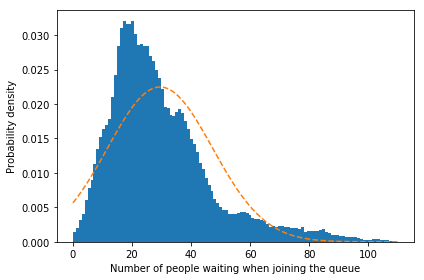

In [29]:
# data to be plotted
mu = fullDataset["waitingPeople"].mean()  # mean of distribution
sigma = fullDataset["waitingPeople"].std()  # standard deviation of distribution
x = fullDataset["waitingPeople"]

num_bins = 111

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Number of people waiting when joining the queue')
ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig('./plots/waitingPeopleHistogram.pdf')

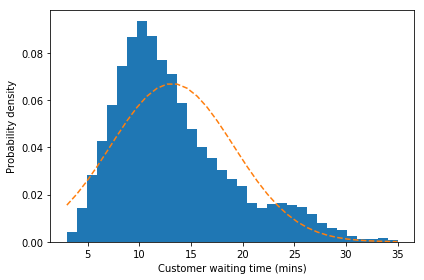

In [30]:
# data to be plotted
mu = fullDataset["waitingTime"].mean()  # mean of distribution
sigma = fullDataset["waitingTime"].std()  # standard deviation of distribution
x = fullDataset["waitingTime"]

num_bins = 33

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Customer waiting time (mins)')
ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig('./plots/waitingTimeHistogram.pdf')

# Feature engineering

In [31]:
workingCopyDataset = fullDataset
workingCopyDataset.drop(['serviceTime'], axis=1);

In [32]:
# mean encoding for regression output
def mean_encoder_regression(input_vector, output_vector):
    assert len(input_vector) == len(output_vector)
    numberOfRows = len(input_vector)

    temp = pd.concat([input_vector, output_vector], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=input_vector.name)[output_vector.name].agg(["mean", "count"])
    
    print(averages)
    return_vector = pd.DataFrame(0, index=np.arange(numberOfRows), columns={'feature'})

    
    for i in range(numberOfRows):
        return_vector.iloc[i] = averages['mean'][input_vector.iloc[i]]
        
    return return_vector

In [33]:
encoded_input_vector_hour = mean_encoder_regression(workingCopyDataset['hour'], workingCopyDataset['waitingTime'])
encoded_input_vector_hour.columns = ['hour']
encoded_input_vector_minutes = mean_encoder_regression(workingCopyDataset['minutes'], workingCopyDataset['waitingTime'])
encoded_input_vector_minutes.columns = ['minutes']
encoded_input_vector_dayOfWeek = mean_encoder_regression(workingCopyDataset['dayOfWeek'], workingCopyDataset['waitingTime'])
encoded_input_vector_dayOfWeek.columns = ['dayOfWeek']

           mean  count
hour                  
8     13.051384  11813
9     13.254895   8682
10    12.870145   6076
11    13.221233   5840
12    12.920947   6249
13    12.961773   5912
14    13.883892   7872
              mean  count
minutes                  
0        13.135930   1258
1        13.314685   1287
2        13.226697    869
3        13.277380    977
4        13.546610    944
5        13.091630   1135
6        13.065407    688
7        13.204373   1052
8        12.918591    823
9        13.226148    849
10       13.048292    849
11       13.296703   1183
12       13.348985    788
13       13.081236    874
14       13.427879    825
15       13.362533   1153
16       13.433721    860
17       13.594793   1229
18       13.262812    761
19       13.344932   1322
20       13.144250   1026
21       13.477866    881
22       14.034848    660
23       12.995430   1094
24       13.451005    796
25       13.028369   1128
26       13.431013    819
27       13.261586    971
28       13.5

In [34]:
X = pd.concat([encoded_input_vector_hour['hour'], encoded_input_vector_minutes['minutes'], pd.DataFrame(workingCopyDataset['waitingPeople']), encoded_input_vector_dayOfWeek['dayOfWeek']], axis=1)
y = workingCopyDataset['waitingTime']

In [35]:
X.describe()

,hour,minutes,waitingPeople,dayOfWeek
count,52444.000000,52444.000000,52444.000000,52444.000000
mean,13.182309,13.182309,29.487434,13.182309
std,0.322024,0.307084,17.753335,0.461623
min,12.870145,12.534854,0.000000,12.815668
25%,12.961773,12.952681,17.000000,12.934124
50%,13.051384,13.178934,26.000000,12.955370
75%,13.254895,13.362533,37.000000,13.092378
max,13.883892,14.034848,110.000000,14.073309


# Prepare data for modeling

In [38]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(41955, 4) (41955,)
(10489, 4) (10489,)


In [39]:
def scale_input(X, means, stds):
    return (X - means) / stds

def descale_input(X, means, stds):
    return (X * stds) + means

In [40]:
meansX = trainX.mean(axis=0)
stdsX = trainX.std(axis=0) + 1e-10

In [41]:
trainX_scaled = scale_input(trainX, meansX, stdsX)
testX_scaled = scale_input(testX, meansX, stdsX)

# Neural network

In [42]:
# create a deep learning model
inputVariables = 4
model = keras.models.Sequential()
model.add(keras.layers.Dense(12, input_dim=inputVariables, kernel_initializer='normal', activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()

model.compile(loss='mae', optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [43]:
# train model
numberOfEpochs = 500
batchSize = 256
history = model.fit(trainX_scaled, trainy, epochs=numberOfEpochs, batch_size=batchSize, verbose=1, validation_split=0.2)

Train on 33564 samples, validate on 8391 samples
Epoch 1/500
33564/33564 [==============================] - 1s 20us/sample - loss: 13.0548 - val_loss: 12.9657
Epoch 2/500
33564/33564 [==============================] - 0s 8us/sample - loss: 12.3883 - val_loss: 11.5661
Epoch 3/500
33564/33564 [==============================] - 0s 6us/sample - loss: 9.3355 - val_loss: 6.6907
Epoch 4/500
33564/33564 [==============================] - 0s 6us/sample - loss: 4.7866 - val_loss: 3.9145
Epoch 5/500
33564/33564 [==============================] - 0s 7us/sample - loss: 3.7927 - val_loss: 3.7450
Epoch 6/500
33564/33564 [==============================] - 0s 8us/sample - loss: 3.7074 - val_loss: 3.6935
Epoch 7/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.6678 - val_loss: 3.6617
Epoch 8/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.6409 - val_loss: 3.6397
Epoch 9/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.6224 - 

33564/33564 [==============================] - 0s 8us/sample - loss: 3.5270 - val_loss: 3.5386
Epoch 77/500
33564/33564 [==============================] - 0s 7us/sample - loss: 3.5266 - val_loss: 3.5381
Epoch 78/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.5266 - val_loss: 3.5383
Epoch 79/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.5258 - val_loss: 3.5375
Epoch 80/500
33564/33564 [==============================] - 0s 7us/sample - loss: 3.5254 - val_loss: 3.5409
Epoch 81/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.5265 - val_loss: 3.5387
Epoch 82/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.5261 - val_loss: 3.5382
Epoch 83/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.5262 - val_loss: 3.5400
Epoch 84/500
33564/33564 [==============================] - 0s 8us/sample - loss: 3.5257 - val_loss: 3.5400
Epoch 85/500
33564/33564 [===============

33564/33564 [==============================] - 0s 6us/sample - loss: 3.3823 - val_loss: 3.3962
Epoch 227/500
33564/33564 [==============================] - 0s 5us/sample - loss: 3.3817 - val_loss: 3.3975
Epoch 228/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.3809 - val_loss: 3.3973
Epoch 229/500
33564/33564 [==============================] - 0s 8us/sample - loss: 3.3810 - val_loss: 3.3993
Epoch 230/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.3820 - val_loss: 3.3956
Epoch 231/500
33564/33564 [==============================] - 0s 5us/sample - loss: 3.3805 - val_loss: 3.3963
Epoch 232/500
33564/33564 [==============================] - 0s 5us/sample - loss: 3.3807 - val_loss: 3.3961
Epoch 233/500
33564/33564 [==============================] - 0s 5us/sample - loss: 3.3796 - val_loss: 3.3961
Epoch 234/500
33564/33564 [==============================] - 0s 8us/sample - loss: 3.3804 - val_loss: 3.3958
Epoch 235/500
33564/33564 [======

33564/33564 [==============================] - 0s 6us/sample - loss: 3.3505 - val_loss: 3.3663
Epoch 377/500
33564/33564 [==============================] - 0s 6us/sample - loss: 3.3500 - val_loss: 3.3644
Epoch 378/500
33564/33564 [==============================] - 1s 17us/sample - loss: 3.3495 - val_loss: 3.3643
Epoch 379/500
33564/33564 [==============================] - 1s 15us/sample - loss: 3.3494 - val_loss: 3.3646
Epoch 380/500
33564/33564 [==============================] - 0s 10us/sample - loss: 3.3502 - val_loss: 3.3647
Epoch 381/500
33564/33564 [==============================] - 0s 7us/sample - loss: 3.3495 - val_loss: 3.3613
Epoch 382/500
33564/33564 [==============================] - 0s 5us/sample - loss: 3.3500 - val_loss: 3.3613
Epoch 383/500
33564/33564 [==============================] - 0s 7us/sample - loss: 3.3488 - val_loss: 3.3647
Epoch 384/500
33564/33564 [==============================] - 0s 7us/sample - loss: 3.3483 - val_loss: 3.3651
Epoch 385/500
33564/33564 [===

In [44]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


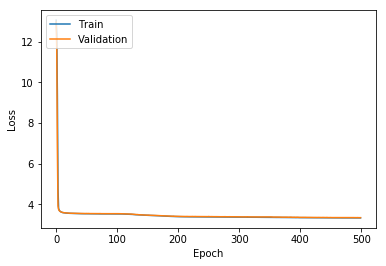

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()
plt.savefig('./plots/loss.pdf')

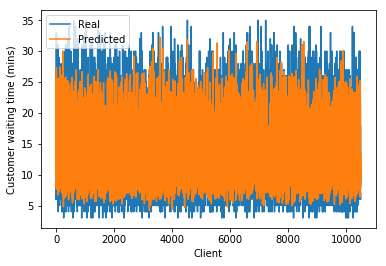

In [48]:
testy_pred = model.predict(testX_scaled)
myLength = len(testy_pred)
plt.plot(range(myLength), testy)
plt.plot(range(myLength), testy_pred)
plt.ylabel('Customer waiting time (mins)')
plt.xlabel('Client')
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.savefig('./plots/realVsPredictedWaitingTimes.pdf')

In [50]:
myMae = mean_absolute_error(testy, testy_pred)
print(f'The mean absolute error I get with the neural network is {myMae} minutes.')

The mean absolute error I get with the neural network is 3.351958487779172 minutes.


In [51]:
myLength = len(testy_pred)
myFMean = np.mean(trainy)
myFMedian = np.median(trainy)
testyMean = testy_pred.copy()
testyMedian = testy_pred.copy()
for i in range(myLength):
    testyMean[i] = myFMean
    testyMedian[i] = myFMedian

In [53]:
myMaeNaiveMean = mean_absolute_error(testy, testyMean)
print(f'The mean absolute error I get with the naive mean model is {myMaeNaiveMean} minutes.')

The mean absolute error I get with the naive mean model is 4.7145383031821275 minutes.


In [54]:
myMaeNaiveMedian = mean_absolute_error(testy, testyMedian)
print(f'The mean absolute error I get with the naive median model is {myMaeNaiveMedian} minutes.')

The mean absolute error I get with the naive median model is 4.59214415101535 minutes.
